# Dataset

In [1]:
model_type = 'convnet' # baseline, resnet, resnet_pretrained, convnet
restart_scheduler = 5

In [11]:
import sys
sys.path.append('../../datasets/')
from prepare_individuals import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [3]:
%load_ext autoreload
%autoreload 2

In [22]:
patch_len = 171990      # 780ms -> 0.78s * 10 -> 7.8 * 22050
patch_skip = 171990
mode = 'slide'
resize = None

X_test, Y_test = prepare("../../datasets/prepared_signal_chirovox.h5", classes, patch_len*8, patch_skip*8, mode, resize, only_test=True)

100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.04it/s]


In [23]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 158
(158, 1375920) (158,)


# Model
Sequence -> Feature map -> pos. encoding -> Transformer (CLS)

In [24]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

sys.path.append('../addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchsummary import summary
from torchmetrics.functional import f1_score

In [25]:
import random
import librosa

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / t.sum()
    return corr

In [26]:
from torchsampler import ImbalancedDatasetSampler
from sklearn.utils import shuffle

batch_size = 64
num_classes = len(list(classes))
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

test_len = batch_size * int(len(X_test) / batch_size)
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
test_loader = DataLoader(test_data, batch_size=batch_size)

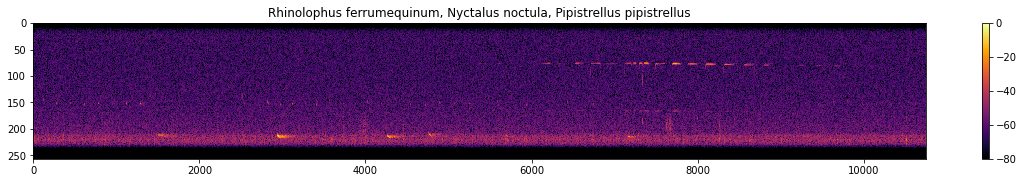

In [30]:
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    D = librosa.stft(seq, n_fft=512)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    spec = np.rot90(np.transpose(S_db))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size-1)
X1, Y1 = next(iter(test_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [32]:
import soundfile as sf
from datetime import datetime

mix = True
sr = 22050
# iterate over test data
for i, (inputs, labels) in enumerate(tqdm.tqdm(test_loader)):
    if mix:
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
    else:
        labels = one_hot(labels, num_classes, device=inputs.device)
    
    for k, (x, y) in enumerate(zip(inputs, labels)):
        label_list = []
        for i in np.argwhere(y == 1)[0]:
            label_list.append(list(classes)[i])
        filename = "./test_files/" + str(datetime.now()) + " - " + ", ".join(label_list) + ".wav"
        sf.write(filename, x, sr * 10)     # de-expand item

100%|█████████████████████████████████████████████| 2/2 [00:31<00:00, 15.70s/it]
